# Human Activity Recognition from Smartphone Sensor Data

#### In this notebook, a CNN model will be trained on a human activity dataset based on smartphone sensor data and predict the activities performed. The model is built using keras and tensorflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, LSTM, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.style.use('seaborn-whitegrid')

2.3.0


# WISDM Dataset

WISDM Dataset is a standard dataset in the field of human activity recognition based on smartphone sensors. This dataset contains accelerometer data from subjects performing 6 different activities

http://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+

In [2]:
#  location of the dataset #
file_location = os.getcwd() + "\\WISDM_ar_v1.1\\"

# Load the dataset into a pandas dataframe
columns  = ["user","activity","timestamp","x","y","z"]
wisdm_df = pd.read_csv(file_location + "WISDM_ar_v1.1_raw.txt",header=None,names=columns,delimiter=",")
wisdm_df

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [3]:
print("Number of subjects :", len(wisdm_df['user'].unique()))
print("Activities :", wisdm_df['activity'].unique())

Number of subjects : 36
Activities : ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [4]:
# remove the semicolon in the z axis data
wisdm_df['z'] = wisdm_df['z'].map(lambda x: x.rstrip(';')) # strip ; from the last value
wisdm_df['z'] = wisdm_df['z'].apply(pd.to_numeric,errors='coerce') # convert values to numerals

In [5]:
print("Number of Null values: \n",)
print(wisdm_df.isna().sum())

Number of Null values: 

user         0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64


In [6]:
print("Rows with defective data: ")
wisdm_df[wisdm_df['timestamp']==0]

Rows with defective data: 


,user,activity,timestamp,x,y,z
14398,20,Walking,0,0.0,0.0,0.0
14399,20,Walking,0,0.0,0.0,0.0
14643,20,Walking,0,0.0,0.0,0.0
14644,20,Walking,0,0.0,0.0,0.0
14645,20,Walking,0,0.0,0.0,0.0
...,...,...,...,...,...,...
882382,3,Walking,0,0.0,0.0,0.0
882383,3,Walking,0,0.0,0.0,0.0
938218,22,Downstairs,0,0.0,0.0,0.0
938219,22,Downstairs,0,0.0,0.0,0.0


In [7]:
# remove defective data from the dataframe 
wisdm_df = wisdm_df[wisdm_df['timestamp']!=0]

Percentage of data for activities:


<AxesSubplot:ylabel='percentage'>

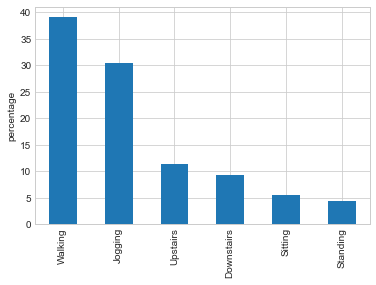

In [8]:
print("Percentage of data for activities:")

(wisdm_df['activity'].value_counts()/len(wisdm_df['activity'])*100).plot(kind='bar',ylabel='percentage')


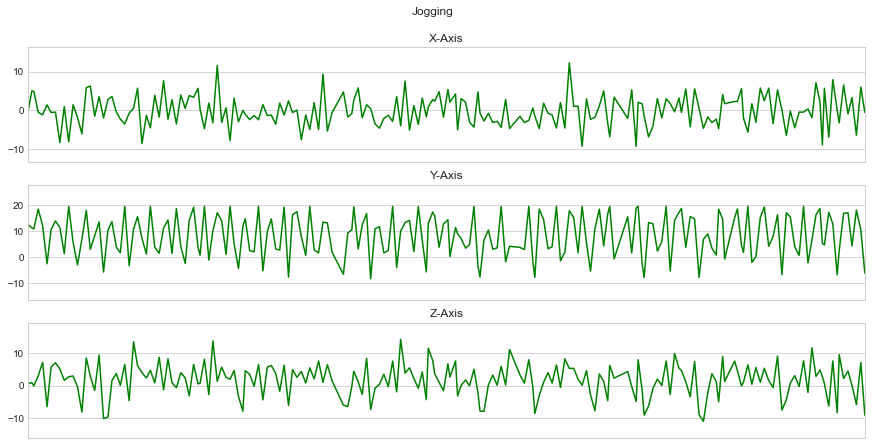

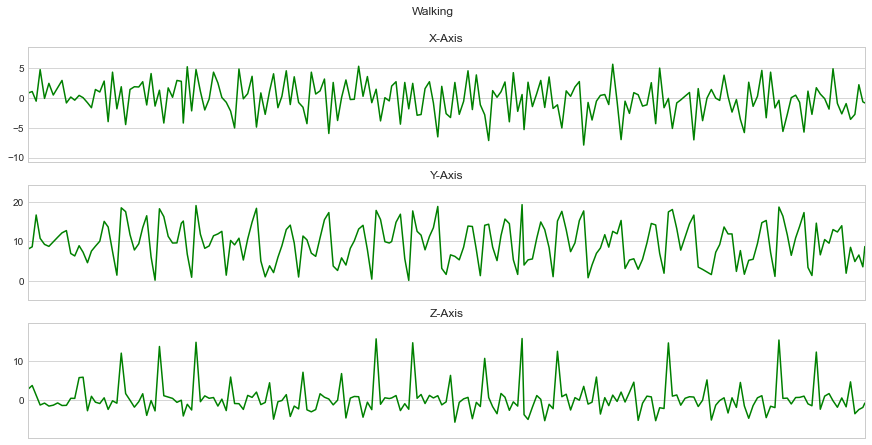

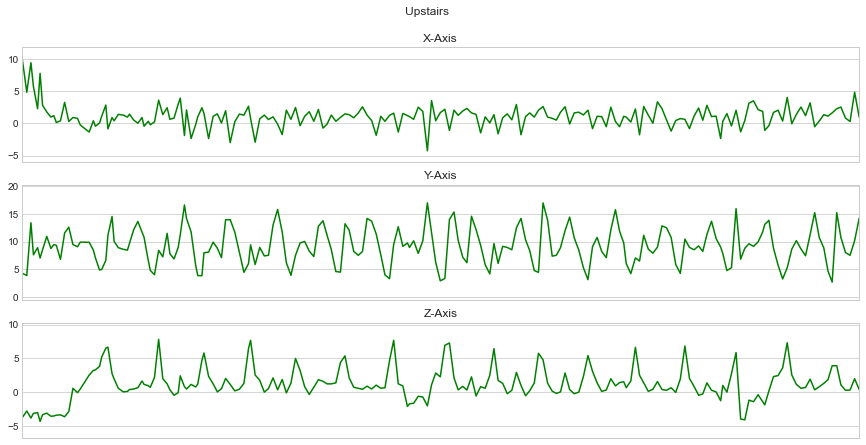

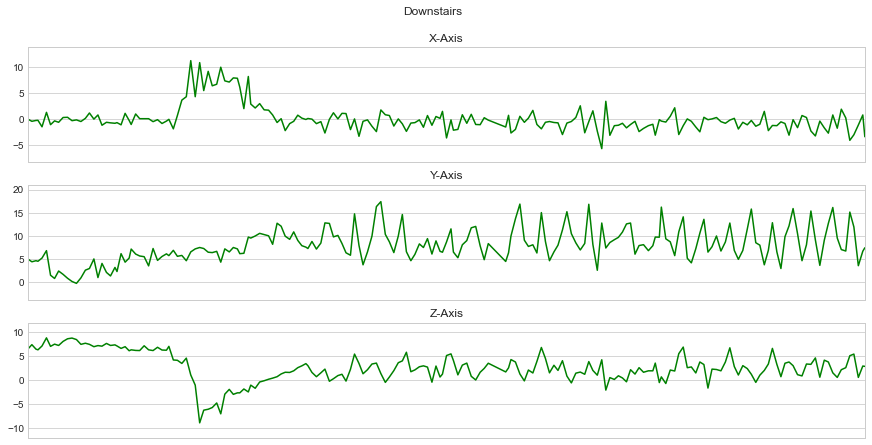

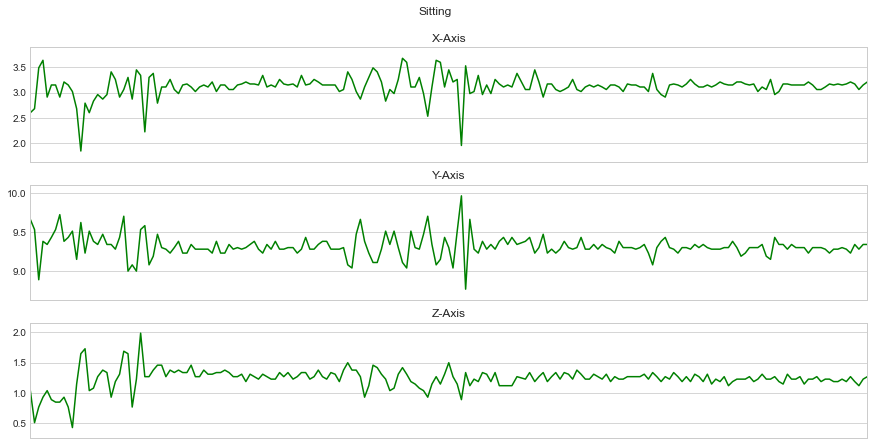

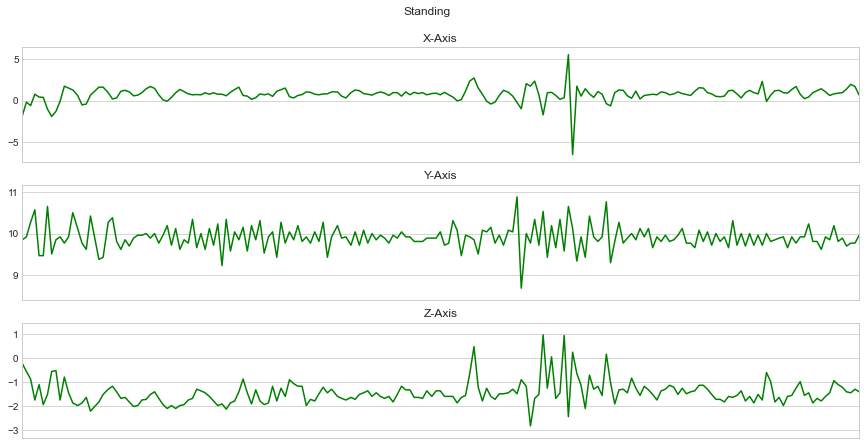

In [9]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

    
Fs = 20
time_sec = 10
activities = wisdm_df['activity'].unique()
for activity in activities:
    data_for_plot = wisdm_df[(wisdm_df['activity'] == activity)][:Fs*time_sec]
    plot_activity(activity, data_for_plot)

In [10]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [11]:
wisdm_df

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [12]:
label = LabelEncoder()
wisdm_df['label'] = label.fit_transform(wisdm_df['activity'])

wisdm_df

G:\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user,activity,timestamp,x,y,z,label
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [13]:
scaler = StandardScaler()
X = wisdm_df[['x', 'y', 'z']]
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = wisdm_df['label'].values

scaled_X

,x,y,z,label
0,-0.198191,0.792216,0.018403,1
1,0.630212,0.582032,0.112397,1
2,0.614395,0.525444,-0.104073,1
3,-0.186329,1.655183,0.545335,1
4,-0.269367,0.707334,1.419757,1
...,...,...,...,...
1085359,1.209058,-1.322293,0.266429,2
1085360,1.214865,-1.305971,0.274794,2
1085361,1.220671,-1.294101,0.266429,2
1085362,1.209058,-1.305971,0.274794,2


In [26]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [27]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [28]:
X, y = get_frames(scaled_X, frame_size, hop_size)
print(X.shape, y.shape)

(27133, 80, 3) (27133,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [30]:
X_train = X_train.reshape(-1, 80, 3, 1)
X_test  = X_test.reshape(-1, 80, 3, 1)

In [31]:
print("Before conversion : ",y_train[0])
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
print("After conversion : ",y_train[0])

Before conversion :  5
After conversion :  [0. 0. 0. 0. 0. 1.]


In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18993, 80, 3, 1) (18993, 6)
(8140, 80, 3, 1) (8140, 6)


In [33]:
# 2D CNN Model
def CNN_model():
    
    model = Sequential()

    model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(1,2))
    model.add(Dropout(0.2,name = 'dropout_layer'))

    model.add(Flatten())
    model.add(Dense(32,activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(6, activation='softmax'))
    
    return model

In [34]:
model = CNN_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 1, 32)         0         
_________________________________________________________________
dropout_layer (Dropout)      (None, 39, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1248)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                3

In [35]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, validation_data= (X_test, y_test), verbose=1)
model.save_weights('model_cnn.h5')

Epoch 1/200
594/594 [==============================] - 2s 4ms/step - loss: 0.8581 - accuracy: 0.6853 - val_loss: 0.5659 - val_accuracy: 0.8045
Epoch 2/200
594/594 [==============================] - 2s 3ms/step - loss: 0.5942 - accuracy: 0.7890 - val_loss: 0.4630 - val_accuracy: 0.8268
Epoch 3/200
594/594 [==============================] - 2s 3ms/step - loss: 0.5399 - accuracy: 0.8037 - val_loss: 0.4236 - val_accuracy: 0.8359
Epoch 4/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4978 - accuracy: 0.8188 - val_loss: 0.3854 - val_accuracy: 0.8484
Epoch 5/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4778 - accuracy: 0.8225 - val_loss: 0.3674 - val_accuracy: 0.8558
Epoch 6/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4534 - accuracy: 0.8321 - val_loss: 0.3543 - val_accuracy: 0.8655
Epoch 7/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4340 - accuracy: 0.8389 - val_loss: 0.3404 - val_accuracy: 0.8731

Epoch 58/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2095 - accuracy: 0.9219 - val_loss: 0.2068 - val_accuracy: 0.9294
Epoch 59/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2194 - accuracy: 0.9195 - val_loss: 0.2087 - val_accuracy: 0.9274
Epoch 60/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2151 - accuracy: 0.9210 - val_loss: 0.1977 - val_accuracy: 0.9329
Epoch 61/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2124 - accuracy: 0.9223 - val_loss: 0.1940 - val_accuracy: 0.9338
Epoch 62/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2113 - accuracy: 0.9223 - val_loss: 0.2008 - val_accuracy: 0.9296
Epoch 63/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2026 - accuracy: 0.9252 - val_loss: 0.2030 - val_accuracy: 0.9307
Epoch 64/200
594/594 [==============================] - 2s 4ms/step - loss: 0.2084 - accuracy: 0.9220 - val_loss: 0.2076 - val_accuracy:

Epoch 115/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1783 - accuracy: 0.9324 - val_loss: 0.1969 - val_accuracy: 0.9330
Epoch 116/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1820 - accuracy: 0.9322 - val_loss: 0.2038 - val_accuracy: 0.9322
Epoch 117/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1787 - accuracy: 0.9334 - val_loss: 0.1971 - val_accuracy: 0.9349
Epoch 118/200
594/594 [==============================] - 2s 4ms/step - loss: 0.1811 - accuracy: 0.9318 - val_loss: 0.2298 - val_accuracy: 0.9290
Epoch 119/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1823 - accuracy: 0.9319 - val_loss: 0.2264 - val_accuracy: 0.9305
Epoch 120/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1830 - accuracy: 0.9322 - val_loss: 0.1875 - val_accuracy: 0.9409
Epoch 121/200
594/594 [==============================] - 2s 4ms/step - loss: 0.1811 - accuracy: 0.9337 - val_loss: 0.2260 - val_ac

594/594 [==============================] - 2s 4ms/step - loss: 0.1687 - accuracy: 0.9372 - val_loss: 0.1873 - val_accuracy: 0.9409
Epoch 172/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1665 - accuracy: 0.9376 - val_loss: 0.2139 - val_accuracy: 0.9348
Epoch 173/200
594/594 [==============================] - 2s 4ms/step - loss: 0.1696 - accuracy: 0.9372 - val_loss: 0.1991 - val_accuracy: 0.9397
Epoch 174/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1709 - accuracy: 0.9373 - val_loss: 0.1851 - val_accuracy: 0.9425
Epoch 175/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1731 - accuracy: 0.9338 - val_loss: 0.2067 - val_accuracy: 0.9345
Epoch 176/200
594/594 [==============================] - 2s 4ms/step - loss: 0.1752 - accuracy: 0.9359 - val_loss: 0.1914 - val_accuracy: 0.9429
Epoch 177/200
594/594 [==============================] - 2s 3ms/step - loss: 0.1699 - accuracy: 0.9386 - val_loss: 0.1912 - val_accuracy: 0.9399

In [36]:
def plot_learningCurve(history, start_epoch,end_epoch):
  # Plot training & validation accuracy values
  epoch_range = range(start_epoch, end_epoch)
  plt.plot(epoch_range, history.history['accuracy'][start_epoch:end_epoch])
  plt.plot(epoch_range, history.history['val_accuracy'][start_epoch:end_epoch])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'][start_epoch:end_epoch])
  plt.plot(epoch_range, history.history['val_loss'][start_epoch:end_epoch])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

Trained for epochs :  200


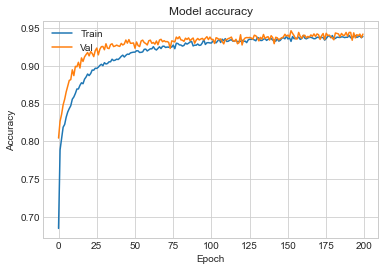

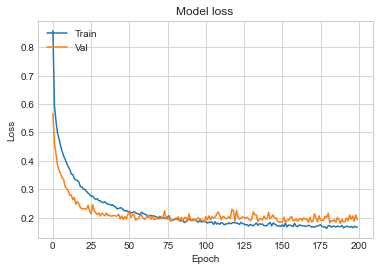

In [37]:
epochs = len(history.history['accuracy'])
print("Trained for epochs : ", epochs)
plot_learningCurve(history, 0, epochs)

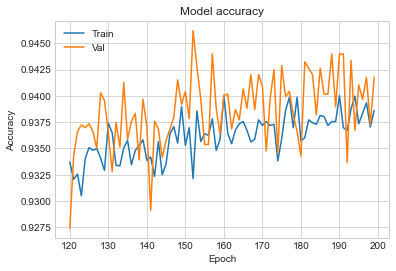

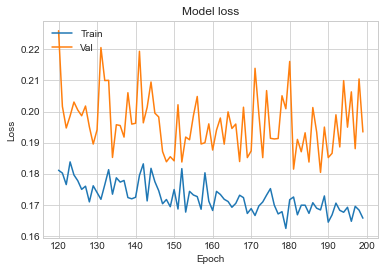

In [39]:
plot_learningCurve(history, 120, epochs)

In [40]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,save_address=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 15,y = 1.02)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize = 15)
    plt.yticks(tick_marks, classes,fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 15)
    
    #plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
    
    if save_address is not None:
        plt.savefig(save_address,bbox_inches='tight')
    plt.show()

In [41]:
acc = model.evaluate(X_test,y_test,verbose = 0)
print("Performance metrics of the model: ")
print("Loss: ",acc[0],"Accuracy: ",acc[1])

Performance metrics of the model: 
Loss:  0.19341112673282623 Accuracy:  0.9417690634727478


G:\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


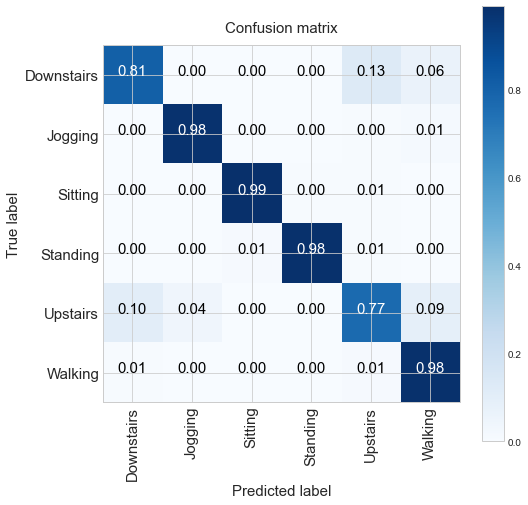

In [42]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(mat,label.classes_)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
        ModelCheckpoint(os.getcwd()+'/weights-CNN_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True),
        EarlyStopping(patience=30, monitor='val_loss', min_delta=0, mode='min'),
]


In [44]:
model = CNN_model()
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, validation_data= (X_test, y_test), verbose=1,callbacks = callbacks)
model.save_weights('model_cnn_callbacks.h5')

Epoch 1/200
594/594 [==============================] - 3s 4ms/step - loss: 0.8208 - accuracy: 0.7091 - val_loss: 0.5049 - val_accuracy: 0.8195
Epoch 2/200
594/594 [==============================] - 2s 3ms/step - loss: 0.5702 - accuracy: 0.7960 - val_loss: 0.4348 - val_accuracy: 0.8383
Epoch 3/200
594/594 [==============================] - 2s 3ms/step - loss: 0.5211 - accuracy: 0.8082 - val_loss: 0.3895 - val_accuracy: 0.8500
Epoch 4/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4774 - accuracy: 0.8196 - val_loss: 0.3708 - val_accuracy: 0.8532
Epoch 5/200
594/594 [==============================] - 2s 3ms/step - loss: 0.4498 - accuracy: 0.8297 - val_loss: 0.3385 - val_accuracy: 0.8635
Epoch 6/200
594/594 [==============================] - 2s 4ms/step - loss: 0.4263 - accuracy: 0.8347 - val_loss: 0.3200 - val_accuracy: 0.8839
Epoch 7/200
594/594 [==============================] - 2s 4ms/step - loss: 0.4075 - accuracy: 0.8418 - val_loss: 0.3203 - val_accuracy: 0.8706

Epoch 58/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2218 - accuracy: 0.9137 - val_loss: 0.1960 - val_accuracy: 0.9386
Epoch 59/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2164 - accuracy: 0.9133 - val_loss: 0.2027 - val_accuracy: 0.9323
Epoch 60/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2152 - accuracy: 0.9147 - val_loss: 0.1956 - val_accuracy: 0.9367
Epoch 61/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2143 - accuracy: 0.9156 - val_loss: 0.1899 - val_accuracy: 0.9389
Epoch 62/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2099 - accuracy: 0.9189 - val_loss: 0.1993 - val_accuracy: 0.9397
Epoch 63/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2157 - accuracy: 0.9143 - val_loss: 0.1978 - val_accuracy: 0.9359
Epoch 64/200
594/594 [==============================] - 2s 3ms/step - loss: 0.2110 - accuracy: 0.9153 - val_loss: 0.1985 - val_accuracy:

Trained for epochs :  102


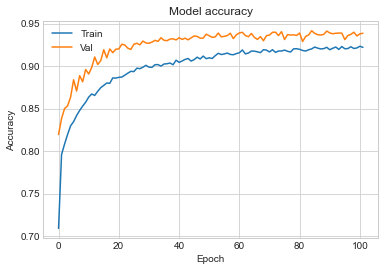

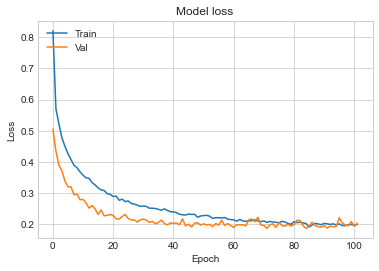

In [45]:
epochs = len(history.history['accuracy'])
print("Trained for epochs : ", epochs)
plot_learningCurve(history, 0, epochs)

In [ ]:
acc = model.evaluate(X_test,y_test,verbose = 0)
print("Performance metrics of the model: ")
print("Loss: ",acc[0],"Accuracy: ",acc[1])

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(mat,label.classes_)